# Predict using minimal data to show true demand

prepare a model that will use only arrival rates and aspirational targes for ED

Inputs
- A series of times in the day at which we want to make these predictions is set 
- A series of dates on which we want to make these predictions
- A time window after the prediction time, within which we are interested in predicting a number of patients (eg 8 hours)

## Set up the notebook environment

In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [2]:
from pathlib import Path
import sys
import json
import pandas as pd
import numpy as np
# import joblib
from joblib import load, dump


PROJECT_ROOT = Path().home() 

# Patient flow package
USER_ROOT = Path().home() / 'work'
sys.path.append(str(USER_ROOT / 'patientflow' / 'src' / 'patientflow'))
sys.path.append(str(USER_ROOT / 'patientflow' / 'functions'))

In [3]:
model_file_path = PROJECT_ROOT /'data' / 'ed-predictor' / 'trained-models'
model_file_path

data_file_path = USER_ROOT / 'ed-predictor' / 'data-raw'
data_file_path



PosixPath('/home/jovyan/work/ed-predictor/data-raw')

## Load parameters

These are set in config.json. You can change these for your own purposes. But the times of day will need to match those in the provided dataset if you want to run this notebook successfully.

In [5]:
# # Load the times of day
# import yaml

# config_path = Path(USER_ROOT / 'patientflow')

# with open(config_path / 'config.yaml', 'r') as file:
#     config = yaml.safe_load(file)
    
# # Convert list of times of day at which predictions will be made (currently stored as lists) to list of tuples
# prediction_times = [tuple(item) for item in config['prediction_times']]
# epsilon = float(eval(config['epsilon']))
# prediction_window = int(config['prediction_window'])
# time_interval = int(config['yta_time_interval'])




## Load data

In [4]:
from ed_admissions_data_retrieval import ed_admissions_get_data
PATH_ED =  str(data_file_path) + '/yet_to_arrive.csv'

df = ed_admissions_get_data(PATH_ED)

In [5]:
df.head()

,training_validation_test,arrival_datetime,sex,specialty,is_child
0,train,2030-11-01 17:40:00+00:00,F,surgical,False
1,train,2030-06-13 19:51:00+00:00,F,haem/onc,False
2,train,2030-04-03 17:39:00+00:00,F,haem/onc,False
3,train,2030-04-12 19:00:00+00:00,F,haem/onc,False
4,train,2030-04-05 18:24:00+00:00,F,haem/onc,False


## Separate into training, validation and test sets

As part of preparing the data, each visit has already been allocated into one of three sets - training, vaidation and test sets. 

In [6]:
df.training_validation_test.value_counts()

training_validation_test
train    22025
test      7705
valid     2493
Name: count, dtype: int64

In [7]:
train_df = df[df.training_validation_test == 'train']#.drop(columns='training_validation_test')
valid_df = df[df.training_validation_test == 'valid']#.drop(columns='training_validation_test')
test_df = df[df.training_validation_test == 'test']#.drop(columns='training_validation_test')

train_df['arrival_datetime'] = pd.to_datetime(train_df['arrival_datetime'], utc = True)
train_df.set_index('arrival_datetime', inplace=True)

/tmp/ipykernel_14482/1241294487.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['arrival_datetime'] = pd.to_datetime(train_df['arrival_datetime'], utc = True)


In [8]:
isinstance(train_df.index, pd.DatetimeIndex)

True

## Get arrival rates by hour

In [10]:
from predict.emergency_demand.time_varying_arrival_rates import calculate_rates
dict = calculate_rates(train_df, time_interval = 60)

Calculating time-varying arrival rates for data provided, which spans 517 days


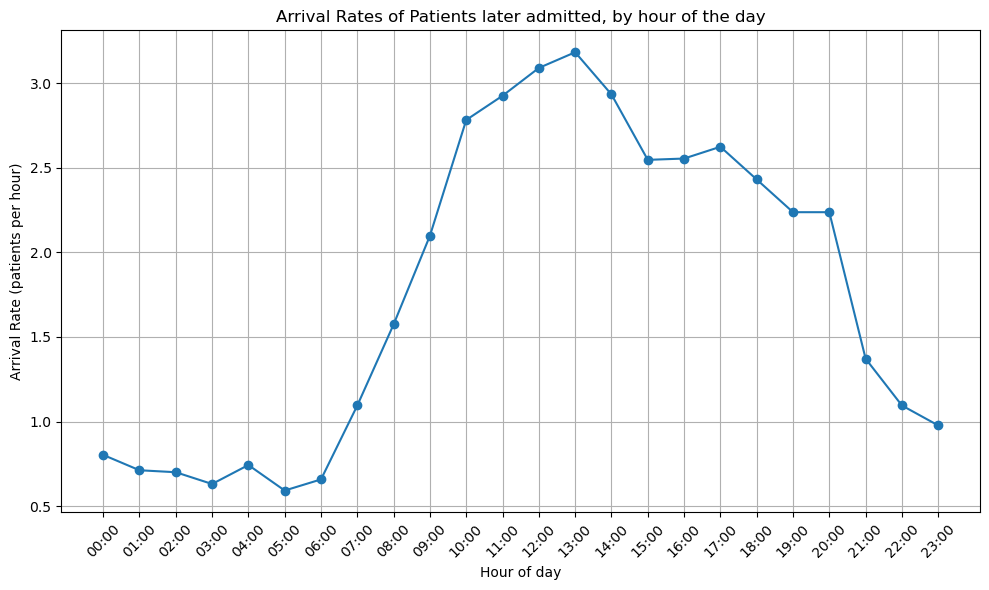

In [13]:
import matplotlib.pyplot as plt
import datetime

# Extract keys and values
hours = list(dict.keys())
arrival_rates = list(dict.values())

# Convert datetime.time objects to strings for better readability on the plot
hour_labels = [hour.strftime('%H:%M') for hour in hours]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(hour_labels, arrival_rates, marker='o')
plt.xticks(rotation=45)
plt.xlabel('Hour of day')
plt.ylabel('Arrival Rate (patients per hour)')
plt.title('Arrival Rates of patients later admitted, by hour of the day')
plt.grid(True)
plt.tight_layout()
plt.show()

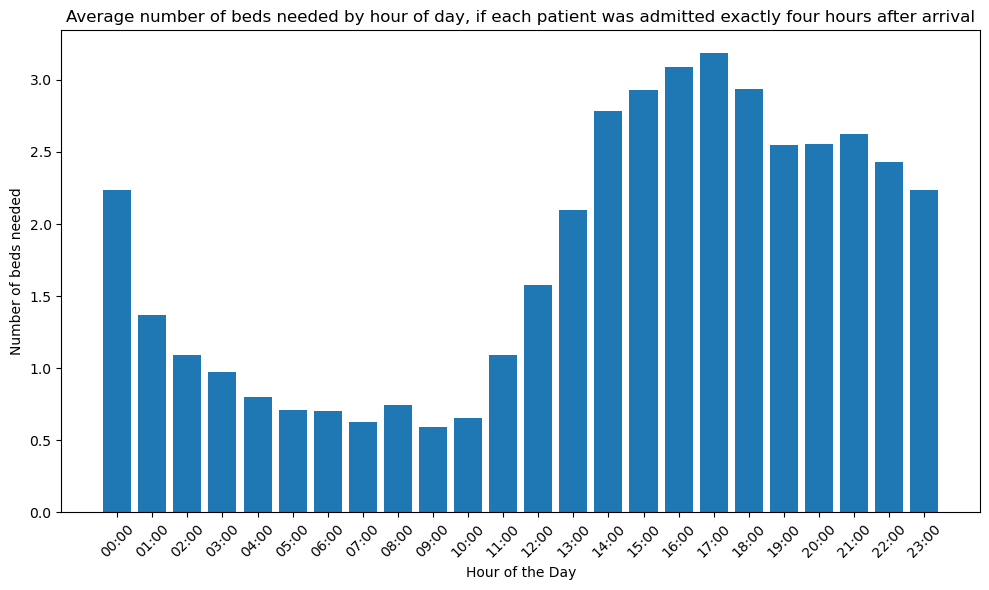

In [26]:
## Lag by four hours

from collections import OrderedDict

# Assuming 'dict' is already defined

# Lag the arrival times by 4 hours
lagged_dict = OrderedDict()
for time, rate in dict.items():
    lagged_time = (datetime.datetime.combine(datetime.date.today(), time) + datetime.timedelta(hours=4)).time()
    lagged_dict[lagged_time] = rate

# Sort the dictionary by the new lagged time
sorted_lagged_dict = OrderedDict(sorted(lagged_dict.items()))

# Extract keys and values from the sorted dictionary
hours = list(sorted_lagged_dict.keys())
arrival_rates = list(sorted_lagged_dict.values())

# Convert datetime.time objects to strings for better readability on the plot
hour_labels = [hour.strftime('%H:%M') for hour in hours]

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(hour_labels, arrival_rates)
plt.xticks(rotation=45)
plt.xlabel('Hour of the Day')
plt.ylabel('Number of beds needed')
plt.title('Average number of beds needed by hour of day, if each patient was admitted exactly four hours after arrival')
# plt.grid(True)
plt.tight_layout()
plt.show()

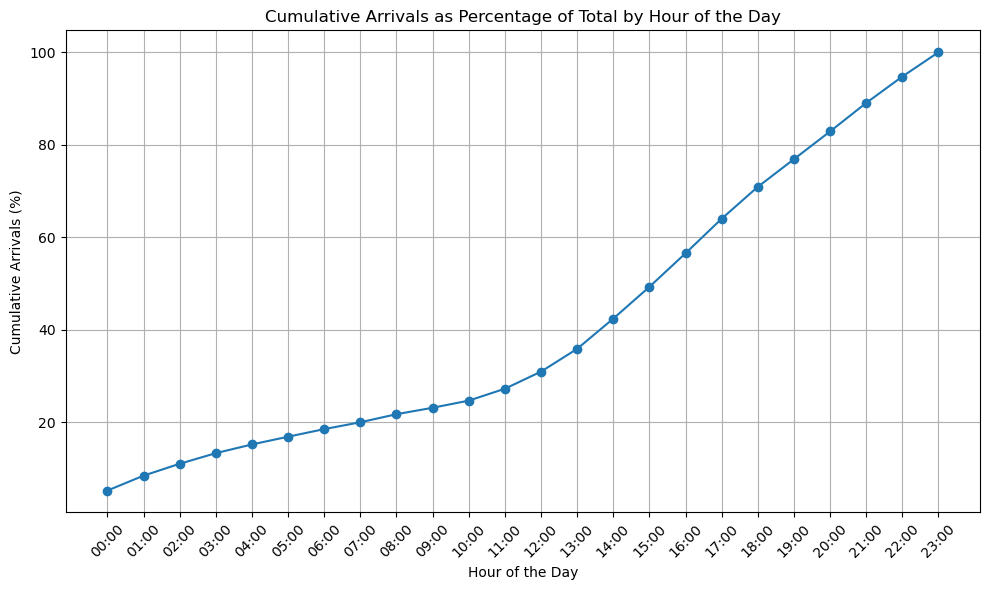

In [27]:
# Cumulative arrival rates

# Calculate cumulative arrivals
total_arrivals = np.sum(arrival_rates)
cumulative_arrivals_percentage = (np.cumsum(arrival_rates) / total_arrivals) * 100


# Plot the cumulative data
plt.figure(figsize=(10, 6))
plt.plot(hour_labels, cumulative_arrivals_percentage, marker='o')
plt.xticks(rotation=45)
plt.xlabel('Hour of the Day')
plt.ylabel('Cumulative Arrivals (%)')
plt.title('Cumulative Arrivals as Percentage of Total by Hour of the Day')
plt.grid(True)
plt.tight_layout()
plt.show()

## For each 

## Train the Poisson-Binomial model

In [27]:
from predict.emergency_demand.poisson_binomial_predictor import PoissonBinomialPredictor

### Train a model for all admission, irrespective of specialty of admission

In [40]:
from predict.emergency_demand.poisson_binomial_predictor import PoissonBinomialPredictor
from joblib import dump, load

model =  PoissonBinomialPredictor()

model.fit(train_df, prediction_window, time_interval, prediction_times)

MODEL__ED_YETTOARRIVE__NAME = 'ed_yet_to_arrive_all_' + str(int(prediction_window/60)) + '_hours'
full_path = model_file_path / MODEL__ED_YETTOARRIVE__NAME 
full_path = full_path.with_suffix('.joblib')

dump(model, full_path)

Calculating time-varying arrival rates for data provided, which spans 520 days
Poisson Binomial Predictor trained for these times: [(6, 0), (9, 30), (12, 0), (15, 30), (22, 0)]
using prediction window of 480 minutes after the time of prediction
and time interval of 15 minutes within the prediction window.
The error value for prediction will be 1e-07
To see the weights saved by this model, used the get_weights() method


['/home/jovyan/data/ed-predictor/trained-models/ed_yet_to_arrive_all_8_hours.joblib']

In [41]:
weights = model.get_weights()


In [42]:
prediction_context = {
    'default': {
        'prediction_time': tuple([7, 0])  
    }
}

x1 = float(config['x1'])
y1 = float(config['y1'])
x2 = float(config['x2'])
y2 = float(config['y2'])

MODEL__ED_YETTOARRIVE__NAME = 'ed_yet_to_arrive_all_' + str(int(prediction_window/60)) + '_hours'
full_path = model_file_path / MODEL__ED_YETTOARRIVE__NAME 
full_path = full_path.with_suffix('.joblib')

model = load(full_path)

preds = model.predict(prediction_context, x1, y1, x2, y2)
preds

/home/jovyan/work/patientflow/src/patientflow/predict/emergency_demand/poisson_binomial_predictor.py:311: UserWarning: Time of day requested of (7, 0) was not in model training. Reverting to predictions for (6, 0).
  warnings.warn(


{'default':      agg_proba
 sum           
 0     0.014505
 1     0.061405
 2     0.129970
 3     0.183398
 4     0.194092
 ..         ...
 220   0.000000
 221   0.000000
 222   0.000000
 223   0.000000
 224   0.000000
 
 [225 rows x 1 columns]}

### Predict within specialty

In [47]:
train_df

,training_validation_test,sex,specialty,is_child
admission_datetime,,,,
2030-06-13 14:33:22+00:00,train,F,haem/onc,False
2030-04-03 10:43:56+00:00,train,F,haem/onc,False
2030-04-12 13:47:06+00:00,train,F,haem/onc,False
2030-04-12 12:33:22+00:00,train,M,haem/onc,False
2030-03-29 16:39:00+00:00,train,F,surgical,False
...,...,...,...,...
2030-11-27 01:57:00+00:00,train,M,NaN,False
2030-11-27 01:50:00+00:00,train,M,NaN,False
2031-02-17 04:33:00+00:00,train,M,NaN,False


In [53]:
from predict.emergency_demand.poisson_binomial_predictor import PoissonBinomialPredictor

specialty_filters = {
    'medical': {'specialty': 'medical', 'is_child': False},
    'surgical': {'specialty': 'surgical', 'is_child': False},
    'haem/onc': {'specialty': 'haem/onc', 'is_child': False},
    'paediatric': {'is_child': True}  # Pediatric doesn't filter by observed_specialty
}

model_by_spec =  PoissonBinomialPredictor(filters = specialty_filters)

model_by_spec.fit(train_df, prediction_window, time_interval, prediction_times)


MODEL__ED_YETTOARRIVE__NAME = 'ed_yet_to_arrive_by_spec_' + str(int(prediction_window/60)) + '_hours'
full_path = model_file_path / MODEL__ED_YETTOARRIVE__NAME 
full_path = full_path.with_suffix('.joblib')

dump(model_by_spec, full_path)

{'medical': {'specialty': 'medical', 'is_child': False}, 'surgical': {'specialty': 'surgical', 'is_child': False}, 'haem/onc': {'specialty': 'haem/onc', 'is_child': False}, 'paediatric': {'is_child': True}}
Calculating time-varying arrival rates for data provided, which spans 519 days
Calculating time-varying arrival rates for data provided, which spans 520 days
Calculating time-varying arrival rates for data provided, which spans 519 days
Calculating time-varying arrival rates for data provided, which spans 519 days
Poisson Binomial Predictor trained for these times: [(6, 0), (9, 30), (12, 0), (15, 30), (22, 0)]
using prediction window of 480 minutes after the time of prediction
and time interval of 15 minutes within the prediction window.
The error value for prediction will be 1e-07
To see the weights saved by this model, used the get_weights() method


['/home/jovyan/data/ed-predictor/trained-models/ed_yet_to_arrive_by_spec_8_hours.joblib']

In [55]:
MODEL__ED_YETTOARRIVE__NAME = 'ed_yet_to_arrive_by_spec_' + str(int(prediction_window/60)) + '_hours'
full_path = model_file_path / MODEL__ED_YETTOARRIVE__NAME 
full_path = full_path.with_suffix('.joblib')

model_by_spec = load(full_path)

x1 = float(config['x1'])
y1 = float(config['y1'])
x2 = float(config['x2'])
y2 = float(config['y2'])

prediction_context = {
    'medical': {
        'prediction_time': tuple([7, 0])  
    }
}

preds = model_by_spec.predict(prediction_context, x1, y1, x2, y2)
preds['medical']

/home/jovyan/work/patientflow/src/patientflow/predict/emergency_demand/poisson_binomial_predictor.py:312: UserWarning: Time of day requested of (7, 0) was not in model training. Reverting to predictions for (6, 0).
  warnings.warn(


,agg_proba
sum,
0,0.145917
1,0.280849
2,0.270277
3,0.173402
4,0.083438
...,...
188,0.000000
189,0.000000
190,0.000000
